# 1.Imports

In [1]:
import glob

from skimage.color import rgb2lab
from skimage.transform import resize

from collections import namedtuple

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

2023-04-13 15:53:12.609069: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 15:53:13.908693: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 15:53:13.930551: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 15:53:17.799496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 2.Hyperparameters

In [2]:
N_CLASSES = 43
RESIZED_IMAGE = (32,32)

# 3.Image Preprocessing

In [3]:
Dataset = namedtuple ('Dataset', ['x', 'y'])

def to_tf_format(imgs):
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis=0).astype(np.float32)

def read_dataset_png(path, n_labels, resize_to):
    images = []
    labels = []
    
    for i in range(n_labels):
        full_path = path + '/' + format(i, 'd') + '/'
        for img_name in glob.glob(full_path + '*.png'):
            img = plt.imread(img_name).astype(np.float32)
            img = rgb2lab(img / 255.0)[:,:,0]
            if resize_to:
                img = resize(img, resize_to, mode='reflect')
            label = np.zeros((n_labels, ), dtype=np.float32)
            label[i] = 1.0
            images.append(img.astype(np.float32))
            labels.append(label)
    return Dataset(x = to_tf_format(images).astype(np.float32),
                  y = np.matrix(labels).astype(np.float32))

dataset = read_dataset_png('gtsdb/Train', N_CLASSES, RESIZED_IMAGE)
print(dataset.x.shape)
print(dataset.y.shape)

(39209, 32, 32, 1)
(39209, 43)


# 4.Printing Example

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


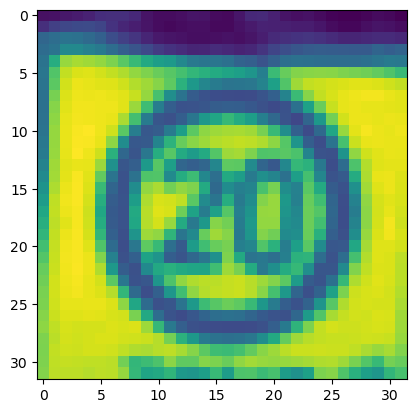

In [4]:
plt.imshow(dataset.x[0, :, :, :].reshape(RESIZED_IMAGE))
print(dataset.y[0, :])

# 5. Train/Test Split

In [5]:
idx_train, idx_test = train_test_split(range(dataset.x.shape[0]), test_size=0.25, random_state=101)
x_train = dataset.x[idx_train, :, :, :]
x_test = dataset.x[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(29406, 32, 32, 1)
(29406, 43)
(9803, 32, 32, 1)
(9803, 43)


# 6. Minibatches

In [6]:
def minibatcher(x, y, batch_size, shuffle):
    assert x.shape[0] == y.shape[0]
    n_samples = x.shape[0]
    if shuffle:
        idx = np.random.permutation(n_samples)
    else:
        idx = list(range(n_samples))
    for j in range(int(np.ceil(n_samples/batch_size))):
        from_idx = j*batch_size
        to_idx = (j+1)*batch_size
        yield x[idx[from_idx:to_idx], :, :, :], y[idx[from_idx:to_idx], :]
        
for mb in minibatcher(x_train, y_train, 10000, True):
    print (mb[0].shape, mb[1].shape)

(10000, 32, 32, 1) (10000, 43)
(10000, 32, 32, 1) (10000, 43)
(9406, 32, 32, 1) (9406, 43)


# 7. Layers and Model

In [7]:
def fc_no_activation_layer(in_tensors, n_units):
    #weights
    w = tf.compat.v1.get_variable('fc_W',
     [in_tensors.get_shape()[1], n_units],
     tf.float32, tf.keras.initializers.GlorotUniform())
    
    #bias
    b = tf.compat.v1.get_variable('fc_B', [n_units, ], tf.float32,
     tf.compat.v1.constant_initializer(0.0))
    
    return tf.matmul(in_tensors, w) + b

def fc_layer(in_tensors, n_units):
    return tf.nn.leaky_relu(fc_no_activation_layer(in_tensors, n_units))

def conv_layer(in_tensors, kernel_size, n_units):
    w = tf.compat.v1.get_variable('conv_W',
     [kernel_size, kernel_size, in_tensors.get_shape()[3], n_units],
     tf.float32, tf.keras.initializers.GlorotUniform())
    
    b = tf.compat.v1.get_variable('conv_B', [n_units, ], tf.float32,
     tf.compat.v1.constant_initializer(0.0))
    
    return tf.nn.leaky_relu(tf.nn.conv2d(in_tensors, w, [1,1,1,1], 'SAME') + b)

def maxpool_layer(in_tensors, sampling):
    return tf.nn.max_pool(in_tensors, [1, sampling, sampling, 1], [1, sampling, sampling, 1], 'SAME')

def dropout(in_tensors, keep_proba, is_training):
    return tf.cond(is_training, lambda: tf.nn.dropout(in_tensors, keep_proba), lambda: in_tensors)

def model(in_tensors, is_training):
    with tf.compat.v1.variable_scope('l1'):
        l1 = maxpool_layer(conv_layer(in_tensors, 5, 32), 2)
        l1_out = dropout(l1, 0.8, is_training)
        
    with tf.compat.v1.variable_scope('l2'):
        l2 = maxpool_layer(conv_layer(l1_out, 5, 64), 2)
        l2_out = dropout(l2, 0.8, is_training)
        
    with tf.compat.v1.variable_scope('flatten'):
        l2_out_flat = tf.keras.layers.Flatten()(l2_out)
        
    with tf.compat.v1.variable_scope('l3'):
        l3 = fc_layer(l2_out_flat, 1024)
        l3_out = dropout(l3, 0.6, is_training)
        
    with tf.compat.v1.variable_scope('out'):
        out_tensors = fc_no_activation_layer(l3_out, N_CLASSES)
    
    return out_tensors

# 8. Training and Results

2023-04-13 15:54:16.944087: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:373] MLIR V1 optimization pass is not enabled


Epoch:  1
 train_loss_score= 3.3825417
Epoch:  2
 train_loss_score= 2.101918
Epoch:  3
 train_loss_score= 1.2046901
Epoch:  4
 train_loss_score= 0.9060294
Epoch:  5
 train_loss_score= 0.7554661
Epoch:  6
 train_loss_score= 0.66201353
Epoch:  7
 train_loss_score= 0.59744006
Epoch:  8
 train_loss_score= 0.5460146
Epoch:  9
 train_loss_score= 0.50242233
Epoch:  10
 train_loss_score= 0.48804227
TEST SET PERFORMANCE


2023-04-13 16:07:06.416341: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1284898816 exceeds 10% of free system memory.
2023-04-13 16:07:08.306797: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 321224704 exceeds 10% of free system memory.
2023-04-13 16:07:09.095569: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 642449408 exceeds 10% of free system memory.
2023-04-13 16:07:13.092205: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 160612352 exceeds 10% of free system memory.


 test_loss_score= 0.1961238
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        67
           1       0.96      0.93      0.94       539
           2       0.92      0.94      0.93       558
           3       0.90      0.94      0.92       364
           4       0.93      0.99      0.96       487
           5       0.92      0.89      0.90       479
           6       1.00      1.00      1.00       105
           7       0.98      0.89      0.94       364
           8       0.93      0.99      0.96       340
           9       1.00      0.98      0.99       384
          10       0.99      0.99      0.99       513
          11       0.99      0.96      0.98       334
          12       0.98      0.98      0.98       545
          13       1.00      0.99      1.00       537
          14       0.96      1.00      0.98       213
          15       0.96      0.99      0.98       164
          16       0.99      1.00      0.99        98

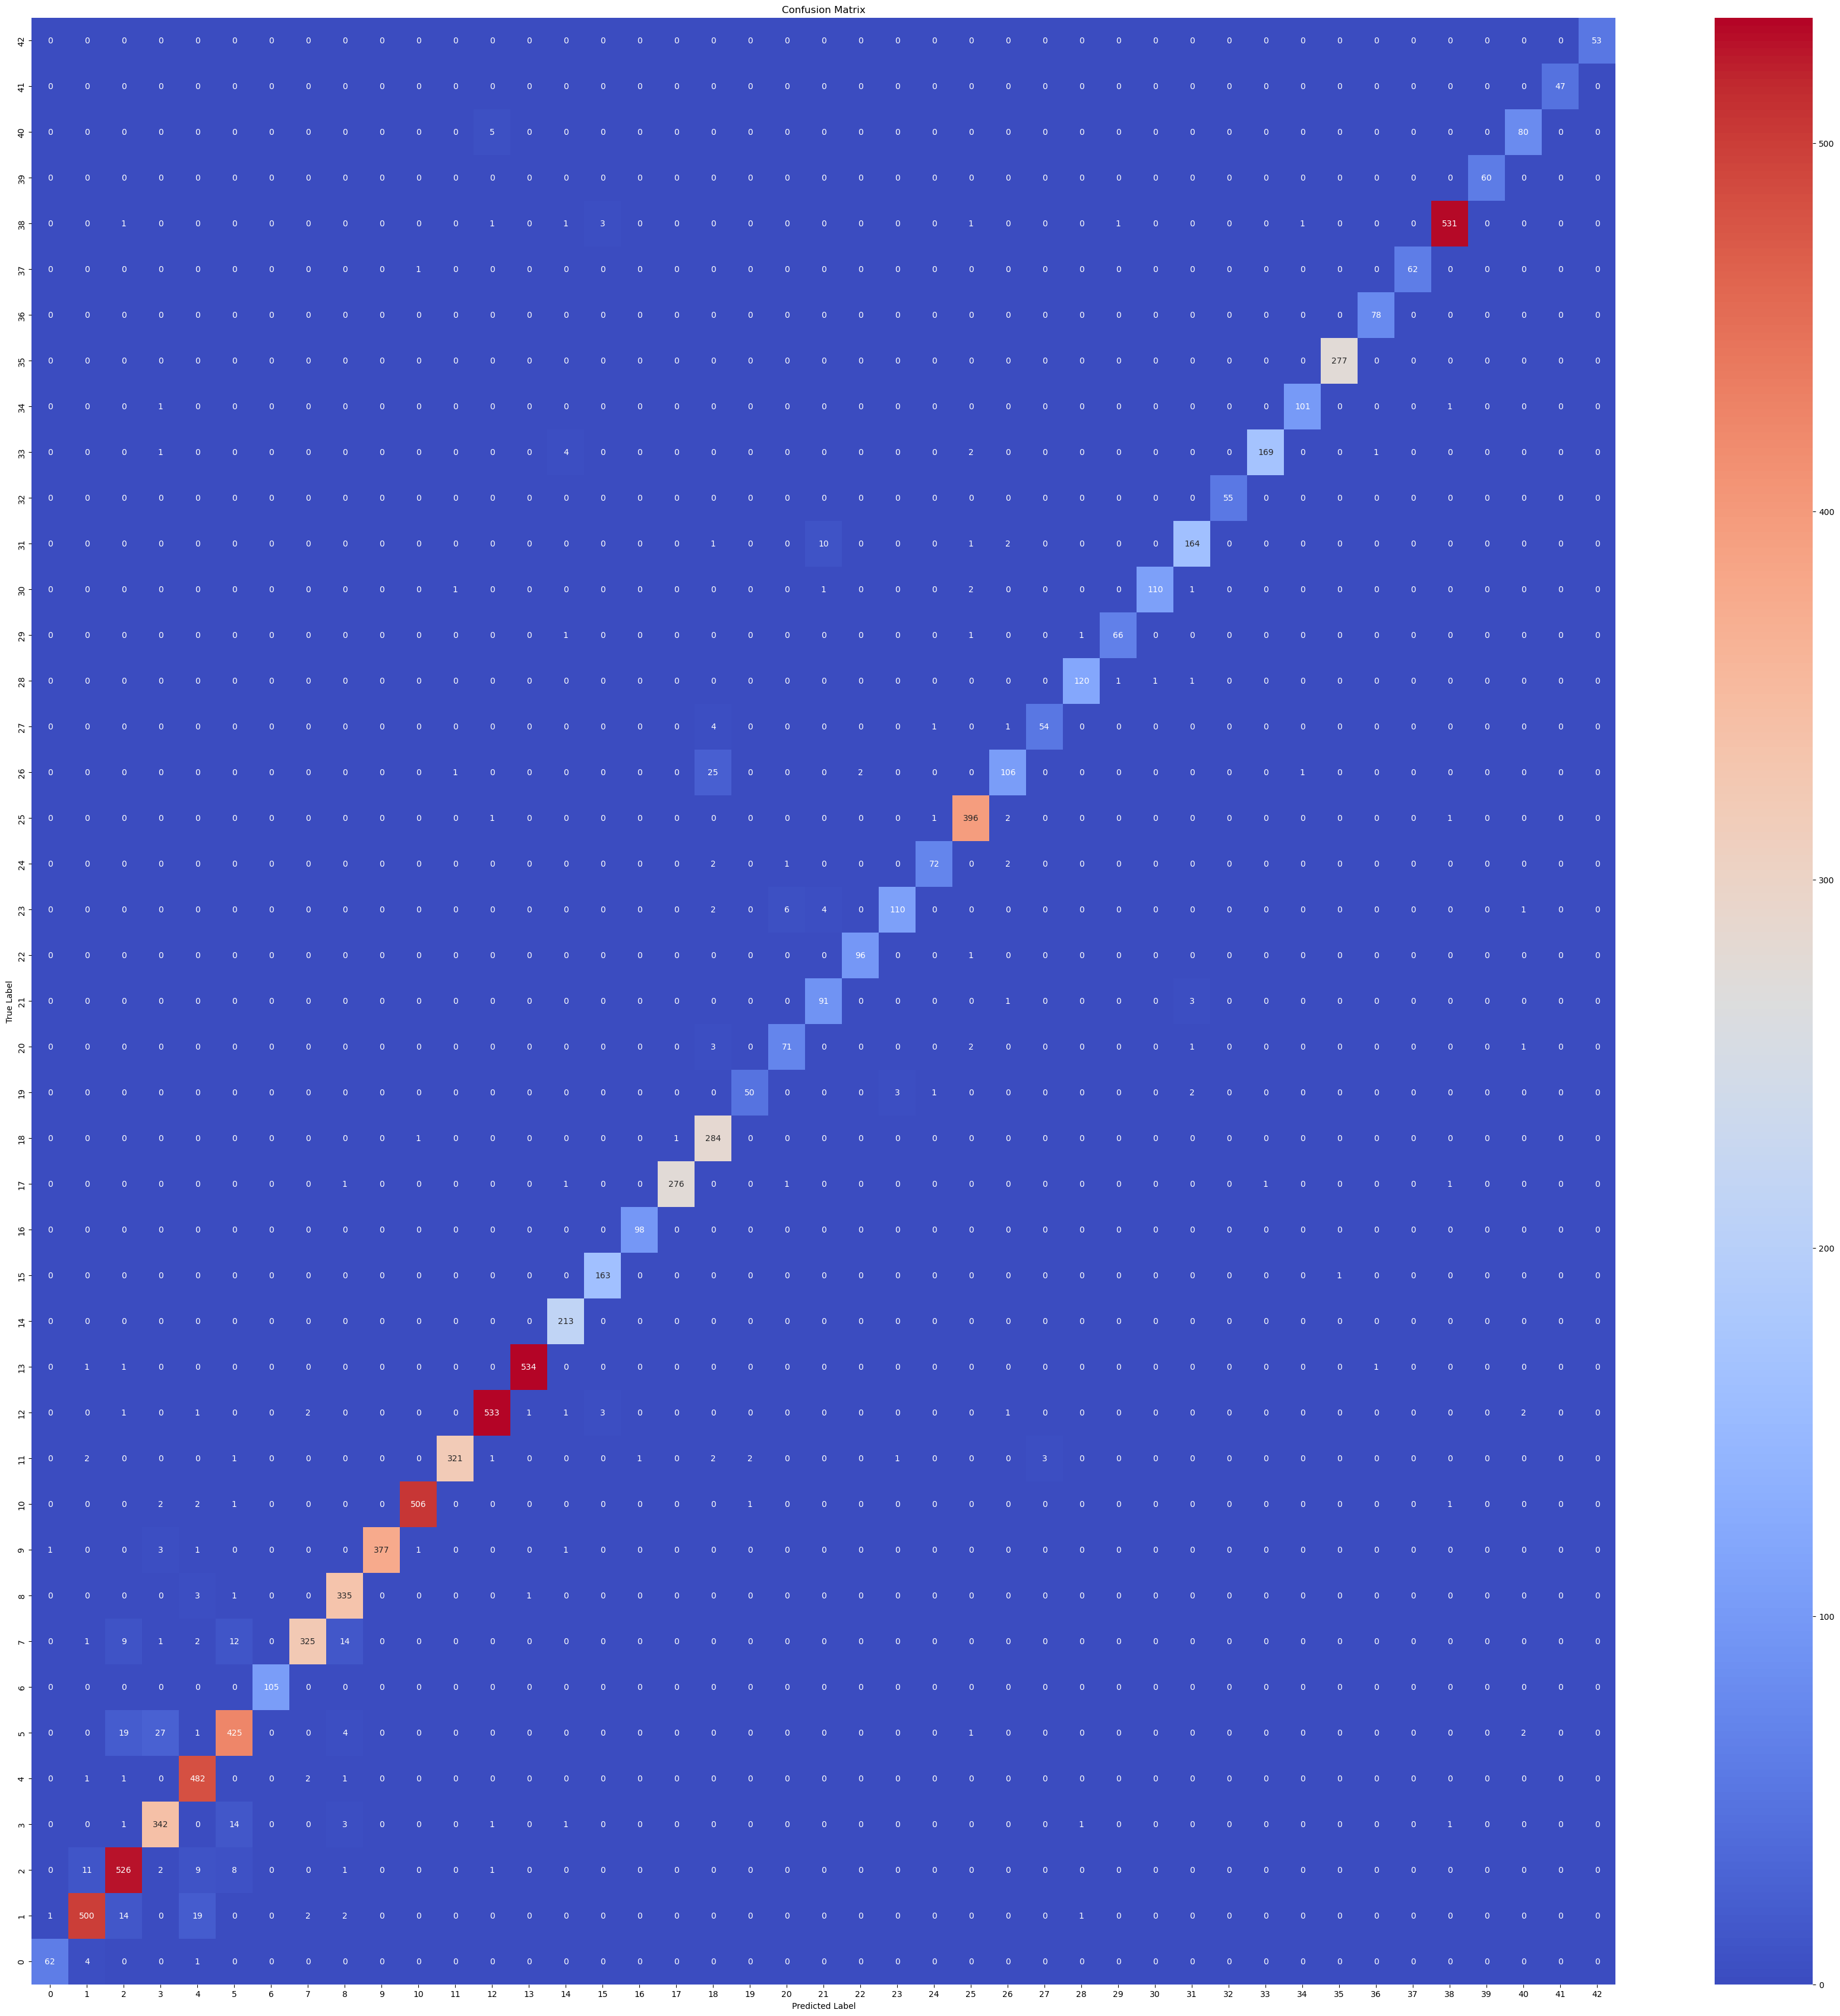

In [8]:
def train_model(x_train, y_train, x_test, y_test, learning_rate, max_epochs, batch_size):
    tf.compat.v1.disable_eager_execution()
    in_x_tensors_batch = tf.compat.v1.placeholder(tf.float32, shape = (None, RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1))
    in_y_tensors_batch = tf.compat.v1.placeholder(tf.float32, shape = (None, N_CLASSES))
    is_training = tf.compat.v1.placeholder(tf.bool)
    
    logits = model(in_x_tensors_batch, is_training)
    out_y_pred = tf.nn.softmax(logits)
    loss_score = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = in_y_tensors_batch)
    loss = tf.reduce_mean(loss_score)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss)
    
    with tf.compat.v1.Session() as session:
        session.run(tf.compat.v1.global_variables_initializer())
        for epoch in range(max_epochs):
            print("Epoch: ", epoch + 1)
            tf_score = []
            for mb in minibatcher(x_train, y_train, batch_size, shuffle = True):
                tf_output = session.run([optimizer, loss],
                 feed_dict = {in_x_tensors_batch : mb[0],
                              in_y_tensors_batch : mb[1],
                              is_training: True})
                tf_score.append(tf_output[1])
            print(" train_loss_score=", np.mean(tf_score))
            
        print("TEST SET PERFORMANCE")
        y_test_pred, test_loss = session.run([out_y_pred, loss],
            feed_dict = {in_x_tensors_batch: x_test,
                         in_y_tensors_batch: y_test,
                         is_training : False})
            
        print(" test_loss_score=", test_loss)
        y_test_pred_classified = np.argmax(y_test_pred, axis=1).astype(np.int32)
        y_test_true_classified = np.argmax(y_test, axis=1).astype(np.int32)
        y_test_pred_classified_conv = np.asarray(y_test_pred_classified)
        y_test_true_classified_conv = np.asarray(y_test_true_classified)
        print(classification_report(y_test_true_classified_conv, y_test_pred_classified_conv))
        
        matrix = metrics.confusion_matrix(y_test_true_classified_conv, y_test_pred_classified_conv)
        plt.figure(figsize=(N_CLASSES, N_CLASSES))
        hm = sns.heatmap(matrix, cmap='coolwarm', annot=True,fmt='d')
        hm.set_ylim(0, len(matrix))
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

tf.compat.v1.reset_default_graph()
train_model(x_train, y_train, x_test, y_test, 0.001, 10, 256)